In [1]:
# Import required libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

In [2]:
# Set the path to the Kodak dataset in parent directory
dataset_path = os.path.join("..", "dataset", "kodak")



In [3]:
# Function to load a specific image by number
def load_kodak_image(image_number):
    """
    Load a specific image from the Kodak dataset
    Args:
        image_number (int): Number of the image (1-24)
    Returns:
        PIL.Image: Loaded image
    """
    # Format the image number with leading zero
    image_name = f"kodim{image_number:02d}.png"
    image_path = os.path.join(dataset_path, image_name)
    
    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image {image_name} not found in {dataset_path}")
    
    # Load and return the image
    return Image.open(image_path)

In [4]:
# Load the first image (kodim01.png)
image = load_kodak_image(1)

# Display basic information about the image
print("Image Mode:", image.mode)
print("Image Size (width x height):", image.size)


Image Mode: RGB
Image Size (width x height): (768, 512)


In [5]:
# Convert to numpy array to check shape and type
image_array = np.array(image)
print("\nNumpy Array Information:")
print("Shape:", image_array.shape)
print("Data Type:", image_array.dtype)



Numpy Array Information:
Shape: (512, 768, 3)
Data Type: uint8


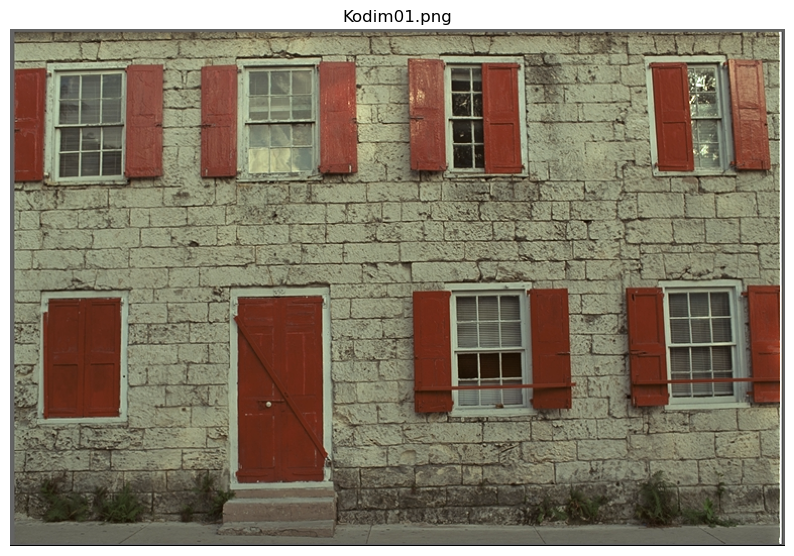

In [6]:
# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.title('Kodim01.png')
plt.show()

In [7]:
def compute_mask(im_shape):
    """Create Bayer pattern mask."""
        
    r_mask = np.zeros(im_shape)
    r_mask[0::2, 0::2] = 1

    g_mask = np.zeros(im_shape)
    g_mask[::2, 1::2] = 1
    g_mask[1::2, ::2] = 1

    b_mask = np.zeros(im_shape)
    b_mask[1::2, 1::2] = 1
    
    mask = np.zeros(im_shape + (3,))
    mask[:, :, 0] = r_mask
    mask[:, :, 1] = g_mask
    mask[:, :, 2] = b_mask
    
    return mask


In [8]:
def process_image(image_path):
    """Process single image to create Bayer pattern."""
    # Read RGB image
    image_gt = cv2.imread(str(image_path))
    b, g, r = cv2.split(image_gt)
    image_gt = cv2.merge([r, g, b])  # BGR to RGB
    
    # Compute mask
    mask = compute_mask(image_gt.shape[:2])
    mask = mask.astype(np.int32)
    
    # Apply mask to create mosaic
    image_mosaic = np.zeros(image_gt.shape).astype(np.int32)
    image_mosaic[:, :, 0] = mask[..., 0] * image_gt[..., 0]
    image_mosaic[:, :, 1] = mask[..., 1] * image_gt[..., 1]
    image_mosaic[:, :, 2] = mask[..., 2] * image_gt[..., 2]
    
    # Sum channels to get Bayer pattern
    image_input = np.sum(image_mosaic, axis=2, dtype='uint16')
    
    return image_gt, mask, image_mosaic, image_input

In [9]:
def visualize_sample_images(dataset_path, num_samples=3):
    image_paths = list(Path(dataset_path).glob('*.png'))
    selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5*num_samples))
    
    for i, path in enumerate(selected_paths):
        image_gt, mask, image_mosaic, image_input = process_image(path)
        
        axes[i,0].imshow(image_gt)
        axes[i,0].set_title(f'Original RGB - {path.name}')
        axes[i,0].axis('off')
        
        axes[i,1].imshow(image_mosaic/255)
        axes[i,1].set_title('Masked RGB')
        axes[i,1].axis('off')
        
        axes[i,2].imshow(image_input, cmap='gray')
        axes[i,2].set_title('Bayer Pattern')
        axes[i,2].axis('off')
    
    plt.tight_layout()
    plt.show()

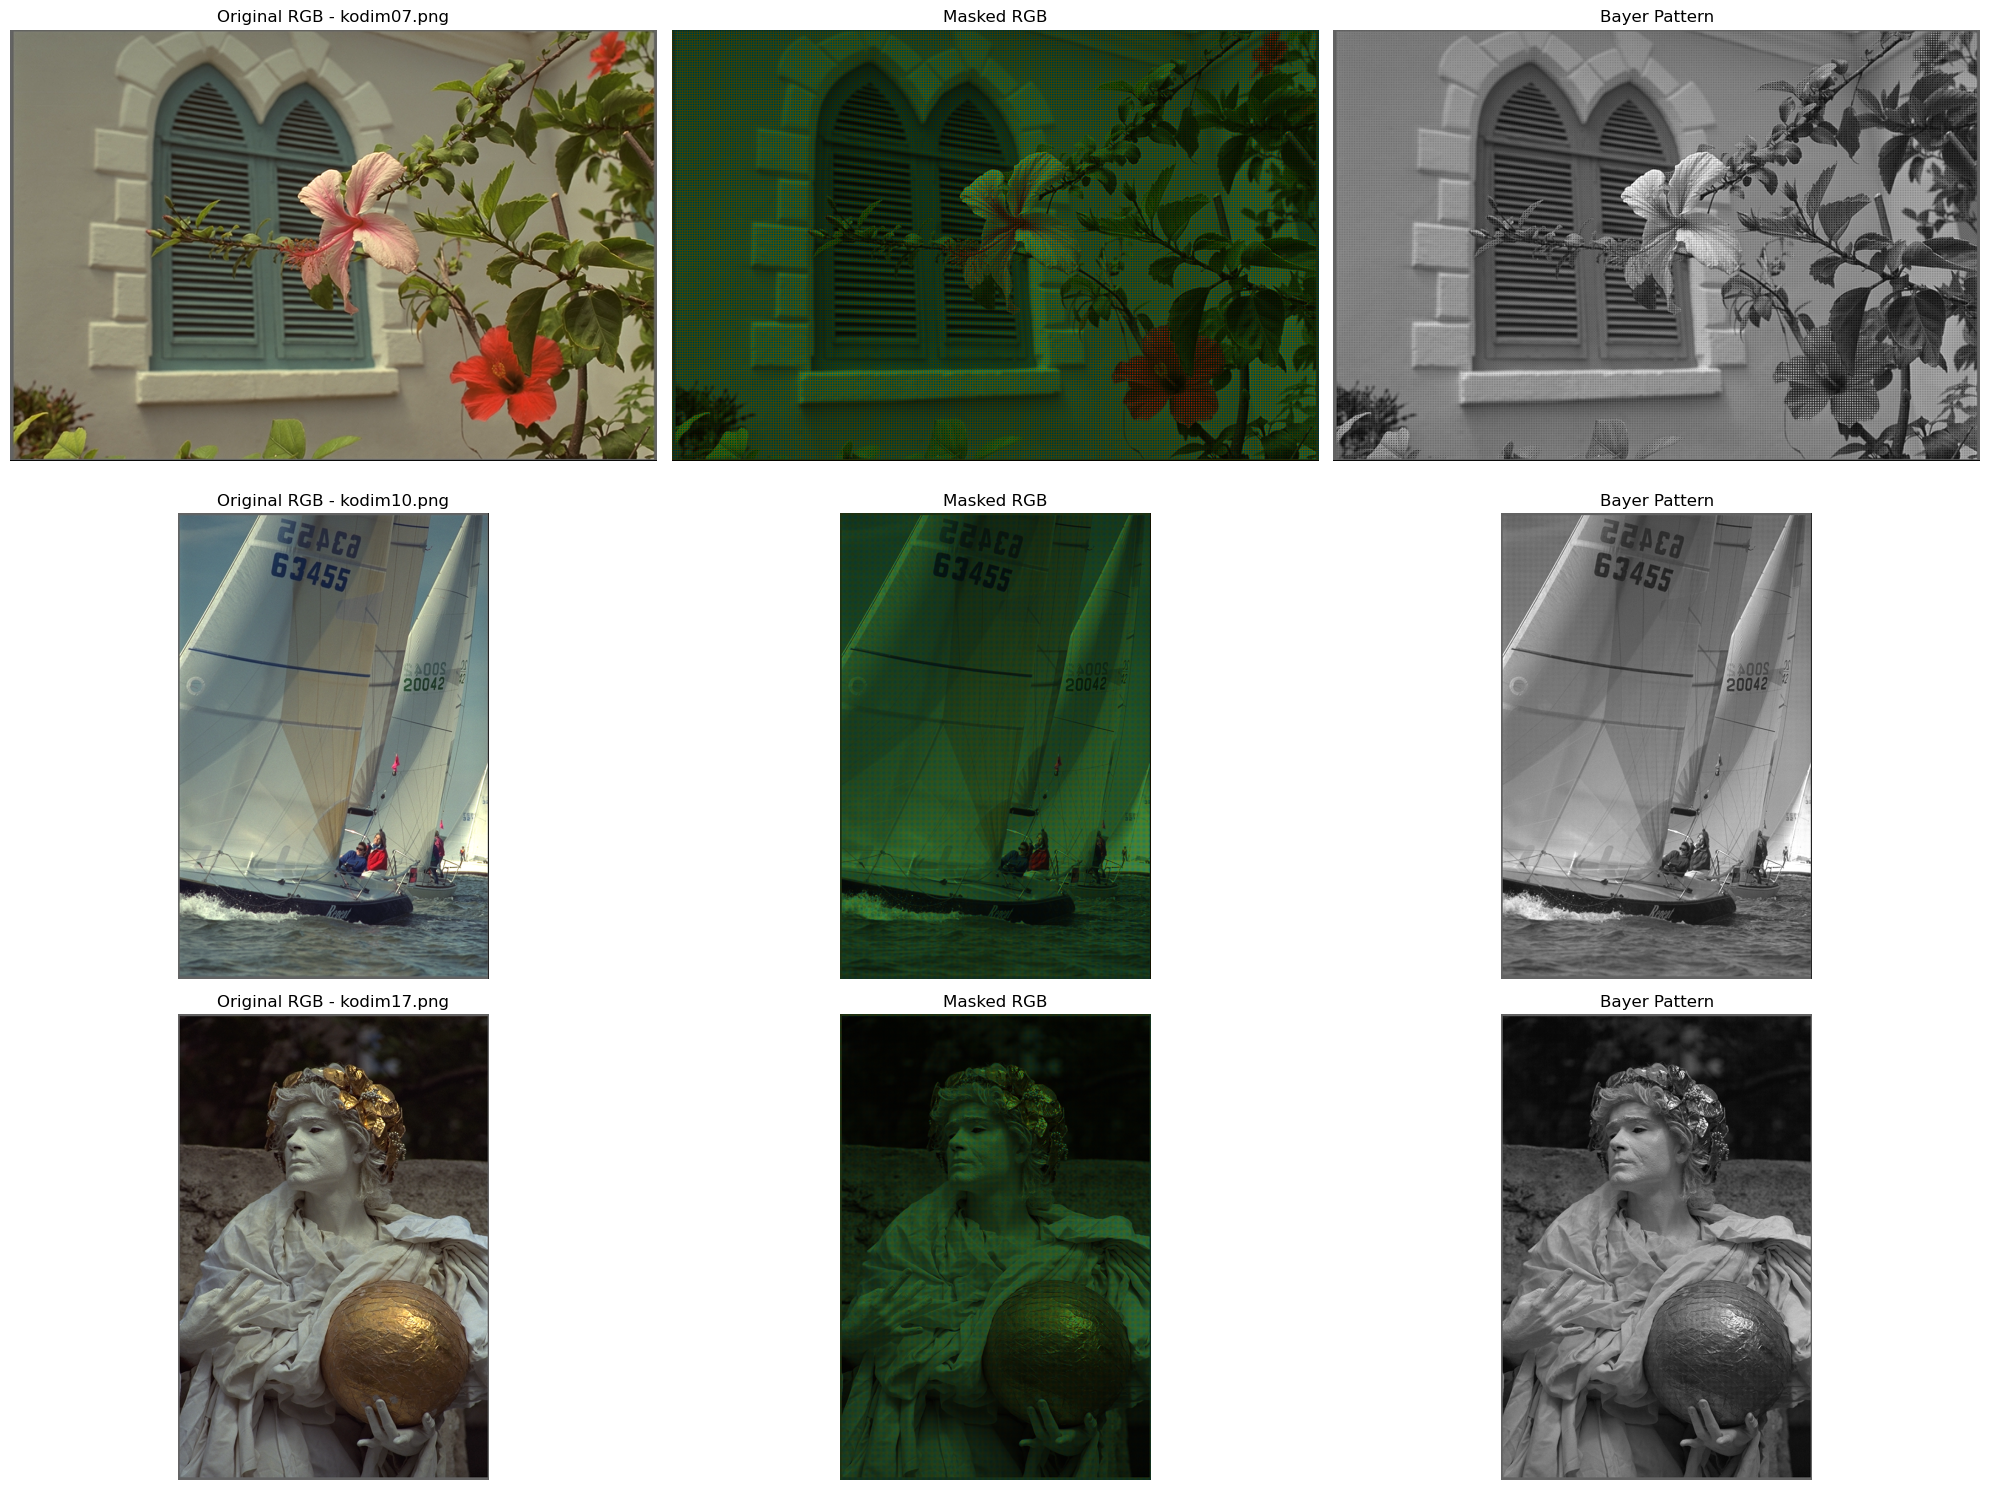

In [10]:
## Showing moisaiced image, with Bayer CFA pattern
dataset_path = os.path.join("..", "dataset", "kodak")
visualize_sample_images(dataset_path, num_samples=3)

In [11]:
# create input and grountruth directory
def process_kodak_dataset():
    # Define paths
    parent_dir = Path('..')
    source_dir = parent_dir / 'dataset' / 'kodak'
    input_dir = parent_dir / 'dataset' / 'kodak' / 'input'
    gt_dir = parent_dir / 'dataset' / 'kodak' / 'groundtruth'
    
    # Create output directories if they don't exist
    input_dir.mkdir(parents=True, exist_ok=True)
    gt_dir.mkdir(parents=True, exist_ok=True)
    
    # Process all images
    for i in range(1, 25):  # Kodak dataset has 24 images
        image_name = f'kodim{i:02d}.png'
        source_path = source_dir / image_name
        
        print(f'Processing {image_name}...')
        
        # Skip if file doesn't exist
        if not source_path.exists():
            print(f'Warning: {image_name} not found, skipping...')
            continue
        
        # Process image
        image_gt, mask, image_mosaic, image_input = process_image(source_path)
        
        # Save ground truth (original RGB image)
        gt_path = gt_dir / image_name
        cv2.imwrite(str(gt_path), cv2.cvtColor(image_gt, cv2.COLOR_RGB2BGR))
        
        # Save input (Bayer pattern)
        input_path = input_dir / image_name
        # Normalize to 8-bit range for grayscale saving
        image_input_normalized = (image_input / image_input.max() * 255).astype(np.uint8)
        cv2.imwrite(str(input_path), image_input_normalized)
        
        print(f'Saved {image_name} to input and groundtruth directories')
        

    
    print('\nProcessing complete!')
    print(f'Input images saved to: {input_dir}')
    print(f'Ground truth images saved to: {gt_dir}')

process_kodak_dataset()

Processing kodim01.png...
Saved kodim01.png to input and groundtruth directories
Processing kodim02.png...
Saved kodim02.png to input and groundtruth directories
Processing kodim03.png...
Saved kodim03.png to input and groundtruth directories
Processing kodim04.png...
Saved kodim04.png to input and groundtruth directories
Processing kodim05.png...
Saved kodim05.png to input and groundtruth directories
Processing kodim06.png...
Saved kodim06.png to input and groundtruth directories
Processing kodim07.png...
Saved kodim07.png to input and groundtruth directories
Processing kodim08.png...
Saved kodim08.png to input and groundtruth directories
Processing kodim09.png...
Saved kodim09.png to input and groundtruth directories
Processing kodim10.png...
Saved kodim10.png to input and groundtruth directories
Processing kodim11.png...
Saved kodim11.png to input and groundtruth directories
Processing kodim12.png...
Saved kodim12.png to input and groundtruth directories
Processing kodim13.png...
Sa